### Option 1

In [1]:
import numpy as np
from sklearn.model_selection import cross_val_score

In [2]:
#data setup
import pandas as pd

df1 = pd.read_csv("C:\Paritosh\SMU\SMUMSDS-ML1\cardio_train.csv", sep=";")
df1.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## Data Cleanup

### Weight and Height

In [3]:
# We address the weight with reasonable weight, the other values probably are a mistake
df1 = df1[df1["weight"] < 200]
df1 = df1[df1["weight"] > 55]

# We address the height, the other values probably are a mistake
df1 = df1[df1["height"] < 200]
df1 = df1[df1["height"] > 130]

### BP Clean up

In [4]:
# Keeping only reasonable blood pressure measurements
df1 = df1[df1["ap_hi"] < 200]
df1 = df1[df1["ap_hi"] > 110]
df1 = df1[df1["ap_lo"] < 150]
df1 = df1[df1["ap_lo"] > 60]

#### Add BMI

In [5]:
# compute the body mass index based on weight and height
df1['bmi'] = df1['weight'] / (df1['height']/100)**2

#### Add bp 

In [6]:
# bin blood pressure groups based on the api hi/ lo variables
df1['bp'] = np.where((df1.ap_hi < 120) & (df1.ap_lo < 80), 1, 0)
df1['bp'] = np.where((df1.ap_hi >= 120) & (df1.ap_hi < 130) & (df1.ap_lo < 80), 2, df1.bp)
df1['bp'] = np.where((df1.ap_hi >= 130) & (df1.ap_hi < 140) | ((df1.ap_lo >= 80) & (df1.ap_lo < 90)), 3, df1.bp)
df1['bp'] = np.where((df1.ap_hi >= 140) | (df1.ap_lo >= 90), 4, df1.bp)
df1['bp'] = np.where((df1.ap_hi > 180) | (df1.ap_lo > 120), 5, df1.bp)
df1['bp1'] = pd.cut(df1.bp,[0,1,2,3,4,5],5,labels=['Normal','Elevated','Hyper_Stage1','Hyper_Stage2','Hyper_Stage3' ]) # this creates a new variable


Our dataset contains primarily people in hypertension stage 1 and stage 2. See the counts below.

In [7]:

#show counts of people in each BMI group

df_grouped = df1.groupby(by='bp1')

df_grouped[['bp']].count()

,bp
bp1,
Normal,177
Elevated,2472
Hyper_Stage1,28219
Hyper_Stage2,22049
Hyper_Stage3,136


In [8]:
#df1.head(5)

## Options

Following are combo I selected based on high correlation and removing 
1.	'bmi', 'ap_hi', 'ap_lo','cholesterol','age' (top 5 co-relation)
2.	'ap_hi' (highest co-relation)
3.	'bmi', 'age', 'ap_lo','ap_hi', 'cholesterol','gluc','smoke','alco','active' (all variable)
4.	‘weight’, 'age', 'ap_lo','ap_hi', 'cholesterol' (replace BMI with weight and drop Height as co-relation is low for height)
5.	'bmi', 'age', ‘bp’, 'cholesterol' (high correlation and removed colinear once)


In [9]:
df=df1
#df
# option 1
y = df['cardio'].values # get the labels we want
df.drop(['id','gender','height','weight','gluc','smoke','alco','active','cardio','bp','bp1'], axis =1, inplace = True) # get rid of the class label
#df.head(5)
X = df.values # Option1
#X

## Option 1 model

In [10]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


### Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l1'],
   'solver': ['liblinear']},
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l2'], 
   'solver': ['lbfgs']},
 ]

lr = LogisticRegression(max_iter=1000)
clf = GridSearchCV(lr, param_grid, scoring="roc_auc",cv=cv_object)
clf.fit(X, y)


clf.cv_results_


{'mean_fit_time': array([0.59676925, 0.82714343, 0.4690938 , 0.56981913, 0.67389536,
        0.20877488, 0.17586263, 0.17718148, 0.15691272, 0.21043698]),
 'std_fit_time': array([0.09953698, 0.1779119 , 0.09510146, 0.16243457, 0.19888046,
        0.07100195, 0.04217917, 0.04620582, 0.05259981, 0.09405589]),
 'mean_score_time': array([0.00700227, 0.0036339 , 0.00364161, 0.00364685, 0.00295989,
        0.00598399, 0.00465504, 0.00332435, 0.00631738, 0.00432158]),
 'std_score_time': array([5.01612216e-03, 4.54131439e-04, 4.59480172e-04, 4.62948024e-04,
        2.28453717e-05, 2.15438807e-03, 1.69654192e-03, 4.69965550e-04,
        2.48858646e-03, 1.88042379e-03]),
 'param_C': masked_array(data=[0.1, 1, 10, 100, 1000, 0.1, 1, 10, 100, 1000],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_penalty': masked_array(data=['l1', 'l1', 'l1', 'l1', 'l1', 'l2', 'l2', 'l2', 'l2'

In [12]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.773379 using {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.773379 (0.006081) with: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.773360 (0.006161) with: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
0.773344 (0.006126) with: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
0.773377 (0.006088) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.773301 (0.006112) with: {'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
0.637127 (0.015915) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.637117 (0.015908) with: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.637116 (0.015907) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.637116 (0.015907) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.683053 (0.070554) with: {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
lr_clf = LogisticRegression(penalty='l1', C=1000, class_weight=None, solver='liblinear' ) # get object




In [14]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
auc 0.7778126510967109
confusion matrix
 [[3381 1311]
 [1732 4187]]
====Iteration 1  ====
auc 0.7732837004564681
confusion matrix
 [[3378 1295]
 [1762 4176]]
====Iteration 2  ====
auc 0.7774341023047546
confusion matrix
 [[3339 1361]
 [1646 4265]]


### train test split

In [15]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

# Scaling

### Logistic Regression Scaled

In [16]:
# from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline


### Hyper Parameter Tuning 

In [17]:

#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l1'],
   'classifier__solver': ['liblinear', 'saga']},
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l2'], 
   'classifier__solver': ['lbfgs', 'sag', 'saga']},
 ]

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs'))])
clf = GridSearchCV(lr, param_grid, scoring="roc_auc", cv=cv_object)
clf.fit(X, y)


clf.cv_results_



{'mean_fit_time': array([0.0724771 , 0.14029209, 0.0588425 , 0.12036641, 0.0681409 ,
        0.11003931, 0.06449445, 0.11868278, 0.05589135, 0.15026553,
        0.03855356, 0.12066483, 0.1067156 , 0.04521147, 0.1698796 ,
        0.1279796 , 0.03623637, 0.16784644, 0.12930894, 0.03658096,
        0.18417303, 0.11136858, 0.0378987 , 0.13830805, 0.10038638]),
 'std_fit_time': array([0.01093367, 0.00870546, 0.00354984, 0.01165632, 0.01434765,
        0.00169528, 0.01155431, 0.02891668, 0.00217465, 0.01434609,
        0.00417367, 0.0111725 , 0.0168263 , 0.00835769, 0.01141046,
        0.01435748, 0.00470168, 0.00122883, 0.01305101, 0.00188802,
        0.02835262, 0.0012445 , 0.00570075, 0.00752963, 0.00385977]),
 'mean_score_time': array([0.00365297, 0.00365599, 0.00465417, 0.00497707, 0.00399963,
        0.00365655, 0.00365678, 0.00365607, 0.00394869, 0.003335  ,
        0.00398819, 0.00332673, 0.0033261 , 0.00531888, 0.00332419,
        0.00498668, 0.00398954, 0.00432316, 0.00332451, 0.00

In [18]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.776381 using {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.776376 (0.001843) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.776381 (0.001843) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.776366 (0.001839) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.776366 (0.001838) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.776365 (0.001838) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.776365 (0.001838) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.776365 (0.001839) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.776365 (0.001838) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.776364 (0.001839)

In [19]:
from sklearn.metrics import roc_auc_score

lr_clf = make_pipeline(StandardScaler(), LogisticRegression(C= 0.1, penalty= 'l1', solver= 'saga'))
model_s=lr_clf
model_s.fit(X_train, y_train)
pred_prob_s = model_s.predict_proba(X_test)
auc_score_s = roc_auc_score(y_test, pred_prob_s[:,1])
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(auc_score_s)
print(accuracies)

0.7772939740908584
[0.7181227  0.71689756 0.71237395]


In [20]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
auc 0.7757609974791919
confusion matrix
 [[3425 1301]
 [1714 4171]]
====Iteration 1  ====
auc 0.7789532951984123
confusion matrix
 [[3418 1332]
 [1659 4202]]
====Iteration 2  ====
auc 0.7750579545752139
confusion matrix
 [[3354 1299]
 [1772 4186]]


In [21]:
"""lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(accuracies)
"""

"lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))\naccuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)\nprint(accuracies)\n"

In [22]:
clf.best_params_

{'classifier__C': 0.1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [23]:
clf.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [24]:
model=clf.best_estimator_.fit(X,y)

In [25]:
model.named_steps["classifier"].coef_

array([[0.29725385, 0.8957176 , 0.12865162, 0.28283007, 0.10075454]])

### precision recall curve

In [26]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

lr_clf.fit(X_train, y_train)

# predict probabilities
lr_probs = lr_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores\
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Logistic: ROC AUC=0.775


<Figure size 640x480 with 1 Axes>



### Option 2

In [27]:
import numpy as np
from sklearn.model_selection import cross_val_score

In [28]:
#data setup
import pandas as pd

df1 = pd.read_csv("C:\Paritosh\SMU\SMUMSDS-ML1\cardio_train.csv", sep=";")
df1.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## Data Cleanup

### Weight and Height

In [29]:
# We address the weight with reasonable weight, the other values probably are a mistake
df1 = df1[df1["weight"] < 200]
df1 = df1[df1["weight"] > 55]

# We address the height, the other values probably are a mistake
df1 = df1[df1["height"] < 200]
df1 = df1[df1["height"] > 130]

### BP Clean up

In [30]:
# Keeping only reasonable blood pressure measurements
df1 = df1[df1["ap_hi"] < 200]
df1 = df1[df1["ap_hi"] > 110]
df1 = df1[df1["ap_lo"] < 150]
df1 = df1[df1["ap_lo"] > 60]

#### Add BMI

In [31]:
# compute the body mass index based on weight and height
df1['bmi'] = df1['weight'] / (df1['height']/100)**2

#### Add bp 

In [32]:
# bin blood pressure groups based on the api hi/ lo variables
df1['bp'] = np.where((df1.ap_hi < 120) & (df1.ap_lo < 80), 1, 0)
df1['bp'] = np.where((df1.ap_hi >= 120) & (df1.ap_hi < 130) & (df1.ap_lo < 80), 2, df1.bp)
df1['bp'] = np.where((df1.ap_hi >= 130) & (df1.ap_hi < 140) | ((df1.ap_lo >= 80) & (df1.ap_lo < 90)), 3, df1.bp)
df1['bp'] = np.where((df1.ap_hi >= 140) | (df1.ap_lo >= 90), 4, df1.bp)
df1['bp'] = np.where((df1.ap_hi > 180) | (df1.ap_lo > 120), 5, df1.bp)
df1['bp1'] = pd.cut(df1.bp,[0,1,2,3,4,5],5,labels=['Normal','Elevated','Hyper_Stage1','Hyper_Stage2','Hyper_Stage3' ]) # this creates a new variable


Our dataset contains primarily people in hypertension stage 1 and stage 2. See the counts below.

In [33]:

#show counts of people in each BMI group

df_grouped = df1.groupby(by='bp1')

df_grouped[['bp']].count()

,bp
bp1,
Normal,177
Elevated,2472
Hyper_Stage1,28219
Hyper_Stage2,22049
Hyper_Stage3,136


In [34]:
df1.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,bp,bp1
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,4,Hyper_Stage2
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,3,Hyper_Stage1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,4,Hyper_Stage2
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0,29.384676,3,Hyper_Stage1
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0,37.729725,3,Hyper_Stage1


## Options

Following are combo I selected based on high correlation and removing 
1.	'bmi', 'ap_hi', 'ap_lo','cholesterol','age' (top 5 co-relation)
2.	'ap_hi' (highest co-relation)
3.	'bmi', 'age', 'ap_lo','ap_hi', 'cholesterol','gluc','smoke','alco','active' (all variable)
4.	‘weight’, 'age', 'ap_lo','ap_hi', 'cholesterol' (replace BMI with weight and drop Height as co-relation is low for height)
5.	'bmi', 'age', ‘bp’, 'cholesterol' (high correlation and removed colinear once)


In [35]:
df=df1
#df
# option 1
y = df['cardio'].values # get the labels we want
df.drop(['id','age','gender','height','weight','ap_lo','cholesterol','gluc','smoke','alco','active','cardio','bmi','bp','bp1'], axis =1, inplace = True) # get rid of the class label
#df.head(5)
X = df.values # Option1
#X

## Option 2 model

In [36]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


### Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
#  {'C': [.1, 1, 10, 100, 1000],
 #  'penalty': ['l1'],
  # 'solver': ['liblinear', 'saga']},
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l2'], 
   'solver': ['lbfgs', 'sag', 'saga']},
 ]

lr = LogisticRegression(max_iter=4000)
clf = GridSearchCV(lr, param_grid, scoring="roc_auc",cv=cv_object)
clf.fit(X, y)


clf.cv_results_

{'mean_fit_time': array([0.06715377, 2.32718468, 3.63931052, 0.05352354, 2.02214718,
        3.6851689 , 0.0418884 , 2.02882441, 3.57047542, 0.04785983,
        2.02494955, 3.58376257, 0.06781888, 1.99593377, 3.53813108]),
 'std_fit_time': array([0.00448684, 0.31920119, 0.05985453, 0.01293594, 0.03740269,
        0.05784741, 0.00081381, 0.05553029, 0.06400667, 0.00706186,
        0.02777344, 0.07860238, 0.01332982, 0.0424709 , 0.04103285]),
 'mean_score_time': array([0.00365583, 0.00395568, 0.00294582, 0.00332403, 0.00298842,
        0.0026323 , 0.00299207, 0.00365559, 0.00263182, 0.0023396 ,
        0.00264359, 0.0033075 , 0.00398922, 0.00462969, 0.00394996]),
 'std_score_time': array([9.39088107e-04, 1.63003243e-03, 8.26212019e-06, 1.88042380e-03,
        8.29912582e-04, 4.50805606e-04, 1.12391596e-07, 4.68617578e-04,
        4.73652910e-04, 4.61339684e-04, 4.58831708e-04, 1.89071105e-03,
        1.62839744e-03, 1.89988598e-03, 1.41524403e-03]),
 'param_C': masked_array(data=[0.1, 0.

In [38]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.735133 using {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.735133 (0.003483) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.735133 (0.003483) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}
0.735133 (0.003483) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
0.735133 (0.003483) with: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.735133 (0.003483) with: {'C': 1, 'penalty': 'l2', 'solver': 'sag'}
0.735133 (0.003483) with: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
0.735133 (0.003483) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.735133 (0.003483) with: {'C': 10, 'penalty': 'l2', 'solver': 'sag'}
0.735133 (0.003483) with: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
0.735133 (0.003483) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.735133 (0.003483) with: {'C': 100, 'penalty': 'l2', 'solver': 'sag'}
0.735133 (0.003483) with: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
0.735133 (0.003483) with: {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
0.7

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
lr_clf = LogisticRegression(penalty='l2', C=0.1, class_weight=None, solver='lbfgs' ) # get object




In [40]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
auc 0.7363849510067295
confusion matrix
 [[3423 1246]
 [1911 4031]]
====Iteration 1  ====
auc 0.7375246503388824
confusion matrix
 [[3384 1301]
 [1838 4088]]
====Iteration 2  ====
auc 0.7327580506037955
confusion matrix
 [[3458 1278]
 [1922 3953]]


### train test split

In [41]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

# Scaling

### Logistic Regression Scaled

In [42]:
# from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline


### Hyper Parameter Tuning 

In [43]:
from sklearn.linear_model import LogisticRegression
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l1'],
   'classifier__solver': ['liblinear', 'saga']},
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l2'], 
   'classifier__solver': ['lbfgs', 'sag', 'saga']},
 ]

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())])
clf = GridSearchCV(lr, param_grid, scoring="roc_auc", cv=cv_object)
clf.fit(X, y)


clf.cv_results_



{'mean_fit_time': array([0.0325791 , 0.07116469, 0.02892232, 0.0730962 , 0.03889481,
        0.0545187 , 0.0279146 , 0.06483905, 0.03257958, 0.06748637,
        0.02127663, 0.07280533, 0.06948074, 0.01762009, 0.11470334,
        0.09506663, 0.0169553 , 0.0887622 , 0.05784512, 0.02393643,
        0.08477259, 0.05053147, 0.01562421, 0.09341677, 0.07446869]),
 'std_fit_time': array([0.0032912 , 0.01220755, 0.00354928, 0.01957796, 0.01345487,
        0.00680523, 0.00244313, 0.00923087, 0.00124277, 0.00981776,
        0.0012439 , 0.00960049, 0.01541438, 0.0032915 , 0.02268182,
        0.03235604, 0.00293731, 0.00453496, 0.00508453, 0.00373092,
        0.01355328, 0.00773932, 0.00308316, 0.01727902, 0.01129311]),
 'mean_score_time': array([0.00432173, 0.00363588, 0.00233873, 0.00265988, 0.00432158,
        0.00399113, 0.0033346 , 0.00398763, 0.00432165, 0.00465401,
        0.00265988, 0.00265956, 0.00365671, 0.00365694, 0.00564011,
        0.0049866 , 0.00398938, 0.00299207, 0.0039889 , 0.00

In [44]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.734673 using {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.734673 (0.005731) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.734673 (0.005731) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.734673 (0.005731) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.734673 (0.005731) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.734673 (0.005731) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.734673 (0.005731) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.734673 (0.005731) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.734673 (0.005731) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.734673 (0.00

In [45]:
from sklearn.metrics import roc_auc_score

lr_clf = make_pipeline(StandardScaler(), LogisticRegression(C= 0.1, penalty= 'l1', solver= 'liblinear'))
model_s=lr_clf
model_s.fit(X_train, y_train)
pred_prob_s = model_s.predict_proba(X_test)
auc_score_s = roc_auc_score(y_test, pred_prob_s[:,1])
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(auc_score_s)
print(accuracies)


0.7327580506037955
[0.70587127 0.69503346 0.70530581]


In [46]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
auc 0.7392666949100711
confusion matrix
 [[3453 1206]
 [1905 4047]]
====Iteration 1  ====
auc 0.7323875924914998
confusion matrix
 [[3444 1238]
 [1934 3995]]
====Iteration 2  ====
auc 0.7273072261367277
confusion matrix
 [[3440 1286]
 [1945 3940]]


In [47]:
"""lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(accuracies)
"""

"lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))\naccuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)\nprint(accuracies)\n"

In [48]:
clf.best_params_

{'classifier__C': 0.1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'liblinear'}

In [49]:
clf.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [50]:
model=clf.best_estimator_.fit(X,y)

In [51]:
model.named_steps["classifier"].coef_

array([[1.09443405]])

### precision recall curve

Logistic: ROC AUC=0.727


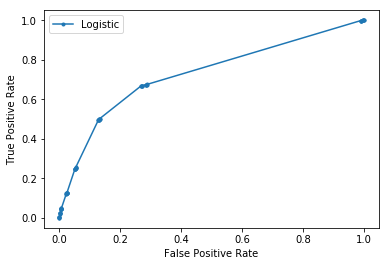

In [52]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

lr_clf.fit(X_train, y_train)

# predict probabilities
lr_probs = lr_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores\
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()




### Option 3

In [53]:
import numpy as np
from sklearn.model_selection import cross_val_score

In [54]:
#data setup
import pandas as pd

df1 = pd.read_csv("C:\Paritosh\SMU\SMUMSDS-ML1\cardio_train.csv", sep=";")
df1.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## Data Cleanup

### Weight and Height

In [55]:
# We address the weight with reasonable weight, the other values probably are a mistake
df1 = df1[df1["weight"] < 200]
df1 = df1[df1["weight"] > 55]

# We address the height, the other values probably are a mistake
df1 = df1[df1["height"] < 200]
df1 = df1[df1["height"] > 130]

### BP Clean up

In [56]:
# Keeping only reasonable blood pressure measurements
df1 = df1[df1["ap_hi"] < 200]
df1 = df1[df1["ap_hi"] > 110]
df1 = df1[df1["ap_lo"] < 150]
df1 = df1[df1["ap_lo"] > 60]

#### Add BMI

In [57]:
# compute the body mass index based on weight and height
df1['bmi'] = df1['weight'] / (df1['height']/100)**2

#### Add bp 

In [58]:
# bin blood pressure groups based on the api hi/ lo variables
df1['bp'] = np.where((df1.ap_hi < 120) & (df1.ap_lo < 80), 1, 0)
df1['bp'] = np.where((df1.ap_hi >= 120) & (df1.ap_hi < 130) & (df1.ap_lo < 80), 2, df1.bp)
df1['bp'] = np.where((df1.ap_hi >= 130) & (df1.ap_hi < 140) | ((df1.ap_lo >= 80) & (df1.ap_lo < 90)), 3, df1.bp)
df1['bp'] = np.where((df1.ap_hi >= 140) | (df1.ap_lo >= 90), 4, df1.bp)
df1['bp'] = np.where((df1.ap_hi > 180) | (df1.ap_lo > 120), 5, df1.bp)
df1['bp1'] = pd.cut(df1.bp,[0,1,2,3,4,5],5,labels=['Normal','Elevated','Hyper_Stage1','Hyper_Stage2','Hyper_Stage3' ]) # this creates a new variable


Our dataset contains primarily people in hypertension stage 1 and stage 2. See the counts below.

In [59]:

#show counts of people in each BMI group

df_grouped = df1.groupby(by='bp1')

df_grouped[['bp']].count()

,bp
bp1,
Normal,177
Elevated,2472
Hyper_Stage1,28219
Hyper_Stage2,22049
Hyper_Stage3,136


In [60]:
df1.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,bp,bp1
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,4,Hyper_Stage2
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,3,Hyper_Stage1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,4,Hyper_Stage2
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0,29.384676,3,Hyper_Stage1
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0,37.729725,3,Hyper_Stage1


## Options

Following are combo I selected based on high correlation and removing 
1.	'bmi', 'ap_hi', 'ap_lo','cholesterol','age' (top 5 co-relation)
2.	'ap_hi' (highest co-relation)
3.	'bmi', 'age', 'ap_lo','ap_hi', 'cholesterol','gluc','smoke','alco','active' (all variable)
4.	‘weight’, 'age', 'ap_lo','ap_hi', 'cholesterol' (replace BMI with weight and drop Height as co-relation is low for height)
5.	'bmi', 'age', ‘bp’, 'cholesterol' (high correlation and removed colinear once)


In [61]:
df=df1
#df
# option 1
y = df['cardio'].values # get the labels we want
df.drop(['id','gender','height','weight','cardio','bp','bp1'], axis =1, inplace = True) # get rid of the class label
#df.head(5)
X = df.values # Option1
#X

## Option 3 model

In [62]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


### Logistic Regression

In [63]:
from sklearn.linear_model import LogisticRegression
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l1'],
   'solver': ['liblinear']},
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l2'], 
   'solver': ['lbfgs']},
 ]

lr = LogisticRegression()
clf = GridSearchCV(lr, param_grid, scoring="roc_auc",cv=cv_object)
clf.fit(X, y)


clf.cv_results_


C:\Users\parit\Anaconda\envs\ML1\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\parit\Anaconda\envs\ML1\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\parit\Anaconda\envs\ML1\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\parit\Anaconda\envs\ML1\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


{'mean_fit_time': array([0.85772761, 1.05984712, 0.89385668, 1.24303007, 0.80253839,
        0.25166003, 0.23107775, 0.24800316, 0.25132895, 0.18483861]),
 'std_fit_time': array([0.11453076, 0.3602612 , 0.27844553, 0.22999703, 0.15472474,
        0.11010601, 0.0640617 , 0.08573024, 0.07164654, 0.06119013]),
 'mean_score_time': array([0.00429519, 0.00396919, 0.0039645 , 0.00629536, 0.00562851,
        0.00432158, 0.00329518, 0.00664941, 0.00465322, 0.00731365]),
 'std_score_time': array([1.26596863e-03, 2.02501463e-05, 1.70713178e-05, 1.87108661e-03,
        1.71076111e-03, 1.24413389e-03, 4.90599204e-04, 1.87969325e-03,
        1.69482766e-03, 4.70077941e-04]),
 'param_C': masked_array(data=[0.1, 1, 10, 100, 1000, 0.1, 1, 10, 100, 1000],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_penalty': masked_array(data=['l1', 'l1', 'l1', 'l1', 'l1', 'l2', 'l2', 'l2', 'l2'

In [64]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.780721 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.780682 (0.000928) with: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.780554 (0.000741) with: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
0.780513 (0.001097) with: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
0.780721 (0.000976) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.780553 (0.000774) with: {'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
0.643137 (0.021177) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.642293 (0.020717) with: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.642999 (0.021360) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.646681 (0.025083) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.642286 (0.020713) with: {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
#LogisticRegression(solver='lbfgs')
lr_clf = LogisticRegression(penalty='l1', C=0.1, class_weight=None, solver='liblinear' ) # get object




In [66]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
auc 0.7854504726435688
confusion matrix
 [[3388 1222]
 [1725 4276]]
====Iteration 1  ====
auc 0.7817470520594516
confusion matrix
 [[3372 1281]
 [1730 4228]]
====Iteration 2  ====
auc 0.7786116035695742
confusion matrix
 [[3399 1389]
 [1631 4192]]


### train test split

In [67]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

# Scaling

### Logistic Regression Scaled

In [68]:
# from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline


### Hyper Parameter Tuning 

In [69]:

#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l1'],
   'classifier__solver': ['liblinear', 'saga']},
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l2'], 
   'classifier__solver': ['lbfgs', 'sag', 'saga']},
 ]

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs'))])
clf = GridSearchCV(lr, param_grid, scoring="roc_auc", cv=cv_object)
clf.fit(X, y)


clf.cv_results_



{'mean_fit_time': array([0.0867784 , 0.19680611, 0.09707483, 0.20843832, 0.08710074,
        0.23805221, 0.08577061, 0.22979315, 0.08510574, 0.19846845,
        0.0468746 , 0.2081097 , 0.17187405, 0.0588429 , 0.26696332,
        0.16589936, 0.04654225, 0.23171298, 0.16057134, 0.06151366,
        0.18784165, 0.15691241, 0.04688811, 0.23803997, 0.16389434]),
 'std_fit_time': array([0.00803452, 0.03944448, 0.02067177, 0.02817772, 0.01924246,
        0.01225835, 0.00081624, 0.0336347 , 0.00896927, 0.02378397,
        0.00635917, 0.0363652 , 0.01964279, 0.0078523 , 0.03987367,
        0.01483394, 0.00094117, 0.00983122, 0.00695654, 0.02439465,
        0.00878869, 0.02823671, 0.00588624, 0.02971557, 0.01459726]),
 'mean_score_time': array([0.00664981, 0.00598502, 0.00797757, 0.00398938, 0.00432142,
        0.00396641, 0.00797892, 0.00464328, 0.00531896, 0.00465504,
        0.00498676, 0.00364582, 0.00365655, 0.00565076, 0.00564138,
        0.00398986, 0.00571744, 0.00399065, 0.00498629, 0.00

In [70]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.777607 using {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.777606 (0.001708) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.777607 (0.001709) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.777585 (0.001702) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.777585 (0.001702) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.777583 (0.001701) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.777582 (0.001701) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.777582 (0.001701) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.777583 (0.001702) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.777582 (0.001701)

In [71]:
from sklearn.metrics import roc_auc_score

lr_clf = make_pipeline(StandardScaler(), LogisticRegression(C= 0.1, penalty= 'l1', solver= 'saga'))
model_s=lr_clf
model_s.fit(X_train, y_train)
pred_prob_s = model_s.predict_proba(X_test)
auc_score_s = roc_auc_score(y_test, pred_prob_s[:,1])
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(auc_score_s)
print(accuracies)


0.7786511652363493
[0.71265668 0.71199698 0.71623787]


In [72]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
auc 0.7773814507479797
confusion matrix
 [[3361 1293]
 [1725 4232]]
====Iteration 1  ====
auc 0.7734876054094295
confusion matrix
 [[3313 1292]
 [1712 4294]]
====Iteration 2  ====
auc 0.7798040522052846
confusion matrix
 [[3402 1324]
 [1699 4186]]


In [73]:
"""lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(accuracies)
"""

"lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))\naccuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)\nprint(accuracies)\n"

In [74]:
clf.best_params_

{'classifier__C': 0.1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [75]:
clf.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [76]:
model=clf.best_estimator_.fit(X,y)

In [77]:
model.named_steps["classifier"].coef_

array([[ 0.29565621,  0.9020981 ,  0.1296683 ,  0.3236999 , -0.07848062,
        -0.03665095, -0.04820689, -0.09434821,  0.10183709]])

### precision recall curve

Logistic: ROC AUC=0.780


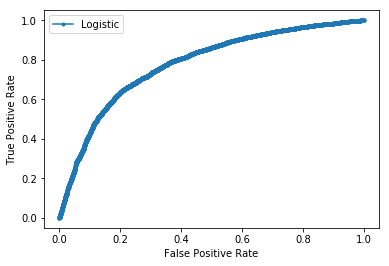

In [78]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

lr_clf.fit(X_train, y_train)

# predict probabilities
lr_probs = lr_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores\
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()



### Option 4

In [79]:
import numpy as np
from sklearn.model_selection import cross_val_score

In [80]:
#data setup
import pandas as pd

df1 = pd.read_csv("C:\Paritosh\SMU\SMUMSDS-ML1\cardio_train.csv", sep=";")
df1.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## Data Cleanup

### Weight and Height

In [81]:
# We address the weight with reasonable weight, the other values probably are a mistake
df1 = df1[df1["weight"] < 200]
df1 = df1[df1["weight"] > 55]

# We address the height, the other values probably are a mistake
df1 = df1[df1["height"] < 200]
df1 = df1[df1["height"] > 130]

### BP Clean up

In [82]:
# Keeping only reasonable blood pressure measurements
df1 = df1[df1["ap_hi"] < 200]
df1 = df1[df1["ap_hi"] > 110]
df1 = df1[df1["ap_lo"] < 150]
df1 = df1[df1["ap_lo"] > 60]

#### Add BMI

In [83]:
# compute the body mass index based on weight and height
df1['bmi'] = df1['weight'] / (df1['height']/100)**2

#### Add bp 

In [84]:
# bin blood pressure groups based on the api hi/ lo variables
df1['bp'] = np.where((df1.ap_hi < 120) & (df1.ap_lo < 80), 1, 0)
df1['bp'] = np.where((df1.ap_hi >= 120) & (df1.ap_hi < 130) & (df1.ap_lo < 80), 2, df1.bp)
df1['bp'] = np.where((df1.ap_hi >= 130) & (df1.ap_hi < 140) | ((df1.ap_lo >= 80) & (df1.ap_lo < 90)), 3, df1.bp)
df1['bp'] = np.where((df1.ap_hi >= 140) | (df1.ap_lo >= 90), 4, df1.bp)
df1['bp'] = np.where((df1.ap_hi > 180) | (df1.ap_lo > 120), 5, df1.bp)
df1['bp1'] = pd.cut(df1.bp,[0,1,2,3,4,5],5,labels=['Normal','Elevated','Hyper_Stage1','Hyper_Stage2','Hyper_Stage3' ]) # this creates a new variable


Our dataset contains primarily people in hypertension stage 1 and stage 2. See the counts below.

In [85]:

#show counts of people in each BMI group

df_grouped = df1.groupby(by='bp1')

df_grouped[['bp']].count()

,bp
bp1,
Normal,177
Elevated,2472
Hyper_Stage1,28219
Hyper_Stage2,22049
Hyper_Stage3,136


In [86]:
df1.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,bp,bp1
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,4,Hyper_Stage2
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,3,Hyper_Stage1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,4,Hyper_Stage2
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0,29.384676,3,Hyper_Stage1
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0,37.729725,3,Hyper_Stage1


## Options

Following are combo I selected based on high correlation and removing 
1.	'bmi', 'ap_hi', 'ap_lo','cholesterol','age' (top 5 co-relation)
2.	'ap_hi' (highest co-relation)
3.	'bmi', 'age', 'ap_lo','ap_hi', 'cholesterol','gluc','smoke','alco','active' (all variable)
4.	‘weight’, 'age', 'ap_lo','ap_hi', 'cholesterol' (replace BMI with weight and drop Height as co-relation is low for height)
5.	'bmi', 'age', ‘bp’, 'cholesterol' (high correlation and removed colinear once)


In [87]:
df=df1
#df
# option 1
y = df['cardio'].values # get the labels we want
df.drop(['id','gender','height','gluc','smoke','alco','active','cardio','bmi','bp','bp1'], axis =1, inplace = True) # get rid of the class label
#df.head(5)
X = df.values # Option1
#X

## Option 4 model

In [88]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


### Logistic Regression

In [89]:

from sklearn.linear_model import LogisticRegression
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l1'],
   'solver': ['liblinear']},
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l2'], 
   'solver': ['lbfgs']},
 ]

lr = LogisticRegression(max_iter=1000)
clf = GridSearchCV(lr, param_grid, scoring="roc_auc",cv=cv_object)
clf.fit(X, y)


clf.cv_results_






{'mean_fit_time': array([0.58977667, 0.61006085, 0.50205167, 0.66789786, 0.62170815,
        0.23470434, 0.16256507, 0.14594237, 0.1791877 , 0.16256571]),
 'std_fit_time': array([0.14277105, 0.12323054, 0.06742446, 0.12424486, 0.14168672,
        0.11365907, 0.02684776, 0.02407847, 0.02394067, 0.0355976 ]),
 'mean_score_time': array([0.00361983, 0.00462731, 0.00363   , 0.00498184, 0.00395195,
        0.00698217, 0.00365702, 0.00498676, 0.00465393, 0.00664822]),
 'std_score_time': array([4.67968739e-04, 9.58724525e-04, 4.85599762e-04, 2.17114763e-03,
        7.80211418e-06, 8.13322746e-04, 9.39425201e-04, 2.15405697e-03,
        1.24273209e-03, 1.24328429e-03]),
 'param_C': masked_array(data=[0.1, 1, 10, 100, 1000, 0.1, 1, 10, 100, 1000],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_penalty': masked_array(data=['l1', 'l1', 'l1', 'l1', 'l1', 'l2', 'l2', 'l2', 'l2'

In [90]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.774747 using {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.774747 (0.002167) with: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.774615 (0.002159) with: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
0.774688 (0.002107) with: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
0.774652 (0.002227) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.774684 (0.002225) with: {'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
0.628749 (0.016055) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.669711 (0.075832) with: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.616423 (0.001405) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.616423 (0.001405) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.616423 (0.001405) with: {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
#LogisticRegression(solver='lbfgs')
lr_clf = LogisticRegression(penalty='l1', C=0.1, class_weight=None, solver='liblinear' ) # get object




In [92]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
auc 0.7829777782643877
confusion matrix
 [[3402 1285]
 [1742 4182]]
====Iteration 1  ====
auc 0.77953422780246
confusion matrix
 [[3366 1317]
 [1697 4231]]
====Iteration 2  ====
auc 0.7747743403872166
confusion matrix
 [[3349 1325]
 [1708 4229]]


### train test split

In [93]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

# Scaling

### Logistic Regression Scaled

In [94]:
# from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline


### Hyper Parameter Tuning 

In [95]:

#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l1'],
   'classifier__solver': ['liblinear', 'saga']},
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l2'], 
   'classifier__solver': ['lbfgs', 'sag', 'saga']},
 ]

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs'))])
clf = GridSearchCV(lr, param_grid, scoring="roc_auc", cv=cv_object)
clf.fit(X, y)


clf.cv_results_



{'mean_fit_time': array([0.08809757, 0.13563728, 0.06482752, 0.16489116, 0.07480113,
        0.14961012, 0.06216677, 0.15092953, 0.05485304, 0.17256172,
        0.04654177, 0.16123454, 0.11635526, 0.03590242, 0.18483822,
        0.13430683, 0.03324374, 0.20578257, 0.15159082, 0.04055818,
        0.19380649, 0.15458751, 0.04986604, 0.21110177, 0.15325602]),
 'std_fit_time': array([0.03218648, 0.01485994, 0.00924807, 0.03804149, 0.01216045,
        0.04236068, 0.00470067, 0.01793922, 0.00293634, 0.02788303,
        0.00835811, 0.01477766, 0.01192058, 0.00162811, 0.0333917 ,
        0.01265079, 0.00046997, 0.00954353, 0.02492565, 0.00308274,
        0.02732095, 0.04044341, 0.01447601, 0.01186529, 0.01681352]),
 'mean_score_time': array([0.00565147, 0.0036575 , 0.00432118, 0.00365742, 0.00398898,
        0.00364661, 0.0043215 , 0.00531912, 0.00365702, 0.00529559,
        0.00365678, 0.0053196 , 0.00398978, 0.00532039, 0.00399025,
        0.00531896, 0.00332483, 0.00631698, 0.00465369, 0.00

In [96]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.781336 using {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.781334 (0.002621) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.781336 (0.002621) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.781326 (0.002616) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.781326 (0.002616) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.781325 (0.002615) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.781324 (0.002615) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.781324 (0.002615) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.781325 (0.002615) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.781323 (0.002614)

In [97]:
from sklearn.metrics import roc_auc_score

lr_clf = make_pipeline(StandardScaler(), LogisticRegression(C= 0.1, penalty= 'l1', solver= 'saga'))
model_s=lr_clf
model_s.fit(X_train, y_train)
pred_prob_s = model_s.predict_proba(X_test)
auc_score_s = roc_auc_score(y_test, pred_prob_s[:,1])
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(auc_score_s)
print(accuracies)


0.774929622251729
[0.71124305 0.71209123 0.70907549]


In [98]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
auc 0.7753158137417063
confusion matrix
 [[3353 1340]
 [1733 4185]]
====Iteration 1  ====
auc 0.7755508656370104
confusion matrix
 [[3434 1287]
 [1762 4128]]
====Iteration 2  ====
auc 0.7724583962001766
confusion matrix
 [[3362 1318]
 [1747 4184]]


In [99]:
"""lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(accuracies)
"""

"lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))\naccuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)\nprint(accuracies)\n"

In [100]:
clf.best_params_

{'classifier__C': 0.1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [101]:
clf.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [102]:
model=clf.best_estimator_.fit(X,y)

In [103]:
model.named_steps["classifier"].coef_

array([[0.30249373, 0.09140337, 0.8996206 , 0.12844921, 0.28637318]])

### precision recall curve

Logistic: ROC AUC=0.772


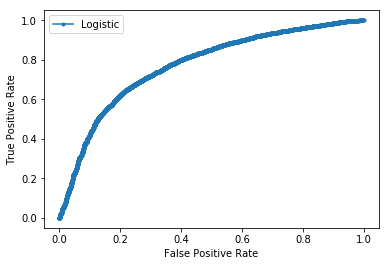

In [104]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

lr_clf.fit(X_train, y_train)

# predict probabilities
lr_probs = lr_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores\
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()




### Option 5

In [105]:
import numpy as np
from sklearn.model_selection import cross_val_score

In [106]:
#data setup
import pandas as pd

df1 = pd.read_csv("C:\Paritosh\SMU\SMUMSDS-ML1\cardio_train.csv", sep=";")
df1.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## Data Cleanup

### Weight and Height

In [107]:
# We address the weight with reasonable weight, the other values probably are a mistake
df1 = df1[df1["weight"] < 200]
df1 = df1[df1["weight"] > 55]

# We address the height, the other values probably are a mistake
df1 = df1[df1["height"] < 200]
df1 = df1[df1["height"] > 130]

### BP Clean up

In [108]:
# Keeping only reasonable blood pressure measurements
df1 = df1[df1["ap_hi"] < 200]
df1 = df1[df1["ap_hi"] > 110]
df1 = df1[df1["ap_lo"] < 150]
df1 = df1[df1["ap_lo"] > 60]

#### Add BMI

In [109]:
# compute the body mass index based on weight and height
df1['bmi'] = df1['weight'] / (df1['height']/100)**2

#### Add bp 

In [110]:
# bin blood pressure groups based on the api hi/ lo variables
df1['bp'] = np.where((df1.ap_hi < 120) & (df1.ap_lo < 80), 1, 0)
df1['bp'] = np.where((df1.ap_hi >= 120) & (df1.ap_hi < 130) & (df1.ap_lo < 80), 2, df1.bp)
df1['bp'] = np.where((df1.ap_hi >= 130) & (df1.ap_hi < 140) | ((df1.ap_lo >= 80) & (df1.ap_lo < 90)), 3, df1.bp)
df1['bp'] = np.where((df1.ap_hi >= 140) | (df1.ap_lo >= 90), 4, df1.bp)
df1['bp'] = np.where((df1.ap_hi > 180) | (df1.ap_lo > 120), 5, df1.bp)
df1['bp1'] = pd.cut(df1.bp,[0,1,2,3,4,5],5,labels=['Normal','Elevated','Hyper_Stage1','Hyper_Stage2','Hyper_Stage3' ]) # this creates a new variable


Our dataset contains primarily people in hypertension stage 1 and stage 2. See the counts below.

In [111]:

#show counts of people in each BMI group

df_grouped = df1.groupby(by='bp1')

df_grouped[['bp']].count()

,bp
bp1,
Normal,177
Elevated,2472
Hyper_Stage1,28219
Hyper_Stage2,22049
Hyper_Stage3,136


In [112]:
df1.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,bp,bp1
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,4,Hyper_Stage2
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,3,Hyper_Stage1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,4,Hyper_Stage2
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0,29.384676,3,Hyper_Stage1
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0,37.729725,3,Hyper_Stage1


## Options

Following are combo I selected based on high correlation and removing 
1.	'bmi', 'ap_hi', 'ap_lo','cholesterol','age' (top 5 co-relation)
2.	'ap_hi' (highest co-relation)
3.	'bmi', 'age', 'ap_lo','ap_hi', 'cholesterol','gluc','smoke','alco','active' (all variable)
4.	‘weight’, 'age', 'ap_lo','ap_hi', 'cholesterol' (replace BMI with weight and drop Height as co-relation is low for height)
5.	'bmi', 'age', ‘bp’, 'cholesterol' (high correlation and removed colinear once)


In [113]:
df=df1
#df
# option 1
y = df['cardio'].values # get the labels we want
df.drop(['id','gender','height','weight','ap_hi','ap_lo','cholesterol','gluc','smoke','alco','active','cardio','bp1'], axis =1, inplace = True) # get rid of the class label
#df.head(5)
X = df.values # Option1
#X

## Option 5 model

In [114]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


### Logistic Regression

In [115]:

from sklearn.linear_model import LogisticRegression
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l1'],
   'solver': ['liblinear']},
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l2'], 
   'solver': ['lbfgs']},
 ]

lr = LogisticRegression(max_iter=1000)
clf = GridSearchCV(lr, param_grid, scoring="roc_auc",cv=cv_object)
clf.fit(X, y)


clf.cv_results_

{'mean_fit_time': array([0.28792159, 0.3982842 , 0.34011745, 0.27063163, 0.29957183,
        0.02470827, 0.02825872, 0.02491188, 0.03523866, 0.03025254]),
 'std_fit_time': array([0.02944319, 0.03942984, 0.08878178, 0.03130499, 0.03117728,
        0.00250116, 0.00248755, 0.00162936, 0.00971533, 0.00692428]),
 'mean_score_time': array([0.0029579 , 0.00430473, 0.00362992, 0.00496467, 0.00361713,
        0.0032169 , 0.0046525 , 0.00332411, 0.00432165, 0.00299136]),
 'std_score_time': array([3.22428747e-06, 4.81892504e-04, 4.74639717e-04, 8.28353901e-04,
        9.35435760e-04, 5.61182179e-04, 2.35229991e-03, 4.68617012e-04,
        1.88070479e-03, 1.32507737e-06]),
 'param_C': masked_array(data=[0.1, 1, 10, 100, 1000, 0.1, 1, 10, 100, 1000],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_penalty': masked_array(data=['l1', 'l1', 'l1', 'l1', 'l1', 'l2', 'l2', 'l2', 'l2'

In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
LogisticRegression()
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' ) # get object




In [117]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
auc 0.6545841722217853
confusion matrix
 [[ 321 4334]
 [ 157 5799]]
====Iteration 1  ====
auc 0.6576116009160325
confusion matrix
 [[ 256 4415]
 [ 154 5786]]
====Iteration 2  ====
auc 0.6506144107276153
confusion matrix
 [[ 403 4267]
 [ 275 5666]]


### train test split

In [118]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

# Scaling

### Logistic Regression Scaled

In [119]:
# from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline


### Hyper Parameter Tuning 

In [120]:
from sklearn.linear_model import LogisticRegression
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l1'],
   'classifier__solver': ['liblinear', 'saga']},
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l2'], 
   'classifier__solver': ['lbfgs', 'sag', 'saga']},
 ]

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs'))])
clf = GridSearchCV(lr, param_grid, scoring="roc_auc", cv=cv_object)
clf.fit(X, y)


clf.cv_results_



{'mean_fit_time': array([0.03557197, 0.08942699, 0.04489152, 0.10970656, 0.04089117,
        0.0997328 , 0.02991954, 0.0930829 , 0.04255311, 0.11668921,
        0.02760235, 0.11135689, 0.10040871, 0.03058624, 0.13398631,
        0.07944194, 0.02359223, 0.12234012, 0.1090529 , 0.03292378,
        0.17496681, 0.10039862, 0.03058441, 0.15358957, 0.078789  ]),
 'std_fit_time': array([0.00308246, 0.00448607, 0.00775783, 0.0171591 , 0.01272123,
        0.00906804, 0.00081459, 0.01164095, 0.00339056, 0.00614811,
        0.00515952, 0.01110522, 0.01970331, 0.00417954, 0.02376628,
        0.01262173, 0.0012312 , 0.01301187, 0.01477985, 0.00734337,
        0.02226991, 0.01186713, 0.00542353, 0.00564352, 0.0048851 ]),
 'mean_score_time': array([0.00432221, 0.00398938, 0.00563947, 0.00531912, 0.00365655,
        0.00565219, 0.00365734, 0.00398993, 0.00433334, 0.00564988,
        0.0056502 , 0.00299287, 0.00431061, 0.00598327, 0.00432189,
        0.00465322, 0.00400066, 0.00365686, 0.00564019, 0.00

In [121]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.743912 using {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.743912 (0.000528) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.743912 (0.000528) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.743911 (0.000528) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.743911 (0.000528) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.743911 (0.000528) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.743911 (0.000528) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.743911 (0.000528) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.743911 (0.000528) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.743911 (0.00

In [122]:
from sklearn.metrics import roc_auc_score

lr_clf = make_pipeline(StandardScaler(), LogisticRegression(C= 0.1, penalty= 'l1', solver= 'liblinear'))
model_s=lr_clf
model_s.fit(X_train, y_train)
pred_prob_s = model_s.predict_proba(X_test)
auc_score_s = roc_auc_score(y_test, pred_prob_s[:,1])
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(auc_score_s)
print(accuracies)


0.7333350033357999
[0.69983979 0.70483461 0.70210159]


In [123]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
auc 0.7449583077169937
confusion matrix
 [[3178 1483]
 [1636 4314]]
====Iteration 1  ====
auc 0.7403036835573813
confusion matrix
 [[3123 1522]
 [1641 4325]]
====Iteration 2  ====
auc 0.7442072616685852
confusion matrix
 [[3157 1549]
 [1602 4303]]


In [124]:
"""lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(accuracies)
"""

"lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))\naccuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)\nprint(accuracies)\n"

In [125]:
clf.best_params_

{'classifier__C': 0.1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'liblinear'}

In [126]:
clf.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [127]:
model=clf.best_estimator_.fit(X,y)

In [128]:
model.named_steps["classifier"].coef_

array([[0.34692142, 0.18307629, 0.79513794]])

### precision recall curve

Logistic: ROC AUC=0.744


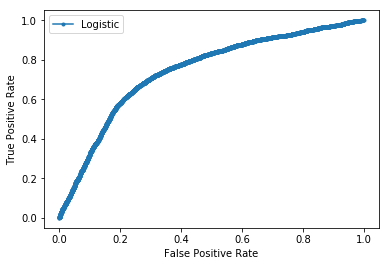

In [129]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

lr_clf.fit(X_train, y_train)

# predict probabilities
lr_probs = lr_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores\
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()